# MARP Results

This notebook reproduces the results of the "MARP" chapter of the manuscript.

In [3]:
# Load the necessary libraries

%load_ext autoreload
%autoreload 2

from marp.mapping import core
from marp.mapping import packer_utils as pu
import onnx
from onnx import numpy_helper as nphelp
import numpy as np
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import onnxruntime as ort
from onnx import helper
import marp.onnx_tools.onnx_utils as onnx_utils
import pandas as pd
import marp.onnx_tools.onnx_splitter as onnx_splitter
import rectpack
import tqdm
import seaborn as sns
from marp.compile import compile

df = pd.DataFrame

def get_packer_string(df_row):
    if df_row['Naive']:
        return 'Naive'
    
    df_row['Offline'] = 'OFF' if df_row['Offline'] else 'ON'
    df_row['SortAlgo'] = '' if df_row['SortAlgo'] == 'SORT_NONE' else df_row['SortAlgo']
    df_row['PackAlgo'] = 'MR' if df_row['PackAlgo'] == 'MaxRectsBssf' else 'SKY'

    return f"{df_row['Offline']}_{df_row['BinAlgo']}_{df_row['PackAlgo']}{df_row['SortAlgo']}"

def get_model_name(df_row):
    return df_row['modelpath'].split('/')[-1].split('.')[0]

## Generate Split Models

Here we generate the split (not necessarily tiled) versions of the ONNX models.
We do this so that the largest layer-equivalent matrices fit in the AIMC core.

To change the core sizes, you can change `C_max` (for the AIMC core rows) and `K_max` (for the AIMC core columns).

These ONNX models are placed into `hwacc_design_garage/onnx_models/*_split.onnx`

This is only done for reference so that we can view them in Netron. For example, [use Netron to inspect the split mbv2 model here](https://netron.app/?url=https://github.com/Lawrence-lugs/hwacc_design_garage/blob/main/onnx_models/mbv2_cifar10_int8_split.onnx).

In [ ]:
modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]
for modelpath in modelpaths:
    nx_model = onnx.load(modelpath)
    onnx_splitter.split_model_to_per_channel(
        nx_model.graph,
        C_max = 256,
        K_max = 256,
        dwC_max= 32)
    onnx.save_model(nx_model, modelpath.replace('.onnx', '_split.onnx'))

## Sample MARP Usage

Here's an example of MARP usage.

Here, we don't need to use a pre-split model because `core.NxModelMapping` already takes `core_size` as an argument and it performs the splits internally.


In [ ]:
# Define onnx model path
modelpath = 'onnx_models/mbv2_cifar10_int8.onnx'

# Define the packer to use from rectpack
# If packer isn't specified, it will use the Dense packer (MaxRectsBssf with BFF Offline) which is the one here.
packer = rectpack.newPacker(
    mode=rectpack.PackingMode.Offline,
    bin_algo=rectpack.PackingBin.BFF, 
    rotation=False, 
    pack_algo=rectpack.MaxRectsBssf
)

core_size = (256, 256)

nx_model = onnx.load(modelpath)
u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer, naive=False)
u_marped.plot()

## Compilation Sample

Warning! MARP Mapping is fast, but compilation is slow for large models (since we currently compile to text instead of binary by default for debugging).

In [ ]:
# Define onnx model path
modelpath = 'onnx_models/ad_quantized_int8.onnx'

# Define the packer to use from rectpack
# If packer isn't specified, it will use the Dense packer (MaxRectsBssf with BFF Offline) which is the one here.
packer = rectpack.newPacker(
    mode=rectpack.PackingMode.Offline,
    bin_algo=rectpack.PackingBin.BFF, 
    rotation=False, 
    pack_algo=rectpack.MaxRectsBssf
)

core_size = (256, 256)

nx_model = onnx.load(modelpath)

input_name = nx_model.graph.input[0].name
input_shape = [d.dim_value for d in nx_model.graph.input[0].type.tensor_type.shape.dim]

# If batch size > 1, set to 1
if input_shape[0] > 1:
    nx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value = 1
    input_shape[0] = 1

np.random.seed(0)
input_dict = {
    input_name: np.random.rand(*input_shape).astype(np.float32)
}

compile.traverse_and_compile_nx_graph(
    nx_model      = nx_model,
    input_dict    = input_dict,
    imc_core_size = core_size,
    dwc_core_size = 32,
    packer        = packer
)

## Results: MARP experients on MBv2

In the next 2 cells, we perform the experiments on MBv2 where we found the Dense, Balanced, and WriteOptimized packers. 

In [ ]:
# Setup sweeps for packing experiments


modes = [
    'ON','OFF'
]

modes_dict = {
    'ON': rectpack.PackingMode.Online,
    'OFF': rectpack.PackingMode.Offline
}

bin_heuristic = [
    'BBF','BNF','BFF'
]

bin_heuristic_dict = {
    'BBF': rectpack.PackingBin.BBF,
    'BNF': rectpack.PackingBin.BNF,
    'BFF': rectpack.PackingBin.BFF
}

fit_heuristic = [
    'BAF','BL','BSSF'
]

fit_heuristic_dict = {
    'BAF': rectpack.MaxRectsBaf,
    'BL': rectpack.MaxRectsBl, 
    'BSSF': rectpack.MaxRectsBssf
}

sort_order = [
    'SO', 'SS', 'SF'
]

sort_order_dict = {
    'SO': rectpack.SORT_NONE,
    'SS': rectpack.SORT_SSIDE,
    'SF': rectpack.SORT_PERI
}

core_size = (256, 256)


modelpath = 'onnx_models/mbv2_cifar10_int8.onnx'


results_df = pd.DataFrame(columns=[
    'Mode', 'Bin Heuristic', 'Fit Heuristic', 'Sort Order','Nwrites','Nbins'
])

for mode in modes:
    for bin_algo in bin_heuristic:
        for pack_algo in fit_heuristic:
            for sort_algo in sort_order:
                try:
                    packer = rectpack.newPacker(
                        mode=modes_dict[mode],
                        bin_algo=bin_heuristic_dict[bin_algo], 
                        rotation=False, 
                        pack_algo=fit_heuristic_dict[pack_algo],
                        sort_algo=sort_order_dict[sort_algo]
                    )
                except:
                    print(f"Skipping {modelpath} with bin_algo={bin_algo}, pack_algo={pack_algo}, sort_algo={sort_algo}")
                    continue
                u_marped = core.NxModelMapping(
                    onnx.load(modelpath),
                    imc_core_size=core_size,
                    packer=packer,
                    naive=False
                )
                u_qracc = core.QRAccModel(
                    u_marped,
                    num_cores=1
                )
                results_df.loc[len(results_df)] = {
                    'Mode': mode,
                    'Bin Heuristic': bin_algo,
                    'Fit Heuristic': pack_algo,
                    'Sort Order': sort_algo,
                    'Nwrites': u_qracc.weight_bin_writes,
                    'Nbins': u_qracc.total_bins
                }

results_df


In [ ]:
sns.set_theme(style="whitegrid")

# fig,ax = plt.subplots(1,2,figsize=(5, 3), dpi=300)

# OFF must be on the left
results_df['Mode'] = pd.Categorical(results_df['Mode'], categories=['OFF', 'ON'], ordered=True)

facetgrid = sns.relplot(
    data=results_df,
    x='Nbins',
    y='Nwrites',
    hue='Bin Heuristic',
    col='Mode',
    style='Fit Heuristic',
    size='Sort Order',
    sizes=(50,150)
)

# Add new datapoint called Conventional Mapping at 91, 92 with a red star
for ax in facetgrid.axes.flat:
    ax.scatter(91, 92, color='red', marker='*', s=150, label='Conventional Mapping', zorder=10)

# Get the legend from the facet grid and add Conventional Mapping
if facetgrid._legend is not None:
    # Get existing legend handles and labels
    handles, labels = facetgrid._legend.legendHandles, [t.get_text() for t in facetgrid._legend.get_texts()]
    
    # Add Conventional Mapping if not present
    if 'Conventional Mapping' not in labels:
        handles.append(plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=10))
        labels.append('Conventional Mapping')
    
    # Update the legend
    facetgrid._legend.remove()
    facetgrid._legend = facetgrid.fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 1), 
                                           fontsize='x-small', frameon=False)

# set legend outside
facetgrid._legend.set_bbox_to_anchor((1.01, 1))
facetgrid._legend.set_loc('upper left')

# set figsize to 5,3 dpi to 300
facetgrid.fig.set_size_inches(5, 3)
facetgrid.set_axis_labels('$N_{bins}$', '$N_{writes}$')
facetgrid.fig.set_dpi(300)

plt.tight_layout()

## Experiments with MLPerfTiny

Next, here are the experiments with the 4 MLPerfTiny models also with varying rectpack hyperparameters.

In [ ]:
# Setup sweeps for packing experiments

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packer_argument_headers = [
    'Naive','Offline','BinAlgo','PackAlgo','SortAlgo'
]
get_packer_arguments = [
    [True,True,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BNF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BFF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BNF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BFF','MaxRectsBssf','SORT_NONE'],
]
core_sizes = [(256,256),(512,512)]

In [ ]:
results = []
with tqdm.tqdm(total=len(modelpaths) * len(core_sizes) * len(get_packer_arguments), desc="Total Progress") as pbar:
    for modelpath in modelpaths:
        for core_size in core_sizes:
            for args in get_packer_arguments:
                packer = pu.get_packer(*args, core_size=core_size)
                nx_model = onnx.load(modelpath)
                u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer)

                if not u_marped.success:
                    print(f"Packing failed for {modelpath} with core size {core_size} and arguments {args}")
                    pbar.update(1)
                    continue

                u_qracc = core.QRAccModel(packed_cgraph=u_marped, num_cores=1)
                results.append({
                    'modelpath': modelpath,
                    'core_size': core_size,
                    'utilization': u_qracc.utilization,
                    'bin_writes': u_qracc.weight_bin_writes,
                    'nbins': u_marped.nbins,
                    **dict(zip(packer_argument_headers, args))
                })
                pbar.update(1)

df = pd.DataFrame(results)
df['PackerArgs'] = df.apply(get_packer_string, axis=1)
df['ModelName'] = df.apply(get_model_name, axis=1)
df.drop(columns=packer_argument_headers, inplace=True)
df.drop(columns=['modelpath'], inplace=True)
df.to_csv('mlperftiny_marp_sweep.csv', index=False)

In [ ]:
sns.set_theme(style="whitegrid")
# Create a new column for marker and color
df['Marker'] = df['PackerArgs'].apply(lambda x: '*' if x == 'Naive' else 'o')
df['Color'] = df['PackerArgs'].apply(lambda x: 'red' if x == 'Naive' else None)

plot_df = df[df['core_size'] == (256, 256)]

marker_dict = {
    'Naive': '*',
    'ON_BBF_MR': 'o',
    'OFF_BBF_MR': 'o',
    'ON_BFF_MR': 'o',
    'OFF_BNF_MR': 'o',
    'ON_BNF_MR': 'o',
    'OFF_BFF_MR': 'o'
}

sizes_dict = {
    'Naive': 300,
    'ON_BBF_MR': 100,
    'OFF_BBF_MR': 100,
    'ON_BFF_MR': 100,
    'OFF_BNF_MR': 100,
    'ON_BNF_MR': 100,
    'OFF_BFF_MR': 100
}

# Create a color palette based on viridis, but set 'Naive' to red
viridis_palette = sns.color_palette("viridis", n_colors=len(marker_dict) - 1)
custom_palette = {'Naive': 'red'}
for k, c in zip([k for k in marker_dict if k != 'Naive'], viridis_palette):
    custom_palette[k] = c

# Plot with custom markers and colors
g = sns.relplot(
    data=plot_df,
    x='bin_writes',
    y='utilization',
    col='ModelName',
    row='core_size',
    hue='PackerArgs',
    kind='scatter',
    palette=custom_palette,
    facet_kws={'sharey': True, 'sharex': False},
    size='PackerArgs',
    sizes=sizes_dict,  # use sizes_dict to set marker sizes
    style='PackerArgs',  # use style to distinguish 'Naive'
    markers=marker_dict
)

# Set red color for 'Naive' points
for ax in g.axes.flat:
    for path_collection, label in zip(ax.collections, g._legend_data.keys()):
        if label == 'Naive':
            path_collection.set_color('red')
g.figure.set_size_inches(8, 2.5)
g.figure.set_dpi(300)
plt.tight_layout()

# set legend outside
g._legend.set_bbox_to_anchor((1.01, 1))
g._legend.set_loc('upper left')
# rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

title_dict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet',
}

# remove everything before = in the titles
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split('=')[-1].strip())
# set titles
for ax in g.axes.flat:
    ax.set_title(title_dict[ax.get_title()])
# set x labels to 'Bin Writes'
for ax in g.axes.flat:
    ax.set_xlabel('Bin Writes')
# set y labels to 'Utilization'
for ax in g.axes.flat:
    ax.set_ylabel('Utilization')

## Results crunching for the Naive packer

Here, we tabulate the results for the Naive packer

In [ ]:
# Get rows where packer is naive
naive_rows = df[df['core_size'] == (256, 256)]
naive_rows = naive_rows.sort_values(by='utilization', ascending=False)
# Use model name as index and pivot the core size
naive_rows

ModelNameDict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet'
}
packerArgsDict = {
    'Naive': 'Naive',
    'OFF_BBF_MR': 'Dense',
    'ON_BBF_MR': 'Balanced',
    'ON_BNF_MR': 'WriteOptimized'
}

# Rename the ModelName column
naive_rows['ModelName'] = naive_rows['ModelName'].apply(lambda x: ModelNameDict.get(x, x))
# Rename the PackerArgs column
naive_rows['PackerArgs'] = naive_rows['PackerArgs'].apply(lambda x: packerArgsDict.get(x, x))
# if the PackerArgs is not in the dict, drop it
naive_rows = naive_rows[naive_rows['PackerArgs'].isin(packerArgsDict.values())]
naive_rows = naive_rows.drop(columns=['core_size'])
naive_rows.set_index(['ModelName', 'PackerArgs'], inplace=True)
naive_rows.rename(columns={'bin_writes': 'Bin Writes', 'utilization': 'Utilization', 'nbins' : '# Bins'}, inplace=True)

# Rename indices to  'ModelName':'Model', 'PackerArgs':'Packer'
naive_rows.index.names = ['Model', 'Packer']
# Sort by ModelName and then by PackerArgs

# sort by ModelName and then by utilization
naive_rows = naive_rows.sort_index(level='Model')
# rename the bin writes column

packer_order = ['Naive', 'Dense', 'Balanced', 'WriteOptimized']
naive_rows = naive_rows.reindex(
    pd.MultiIndex.from_product(
        [naive_rows.index.levels[0], packer_order],
        names=naive_rows.index.names
    ),
    fill_value=np.nan
)

naive_rows.to_csv('naive_mlperftiny.csv')
naive_rows

## Plots for the 4 packer types on each model

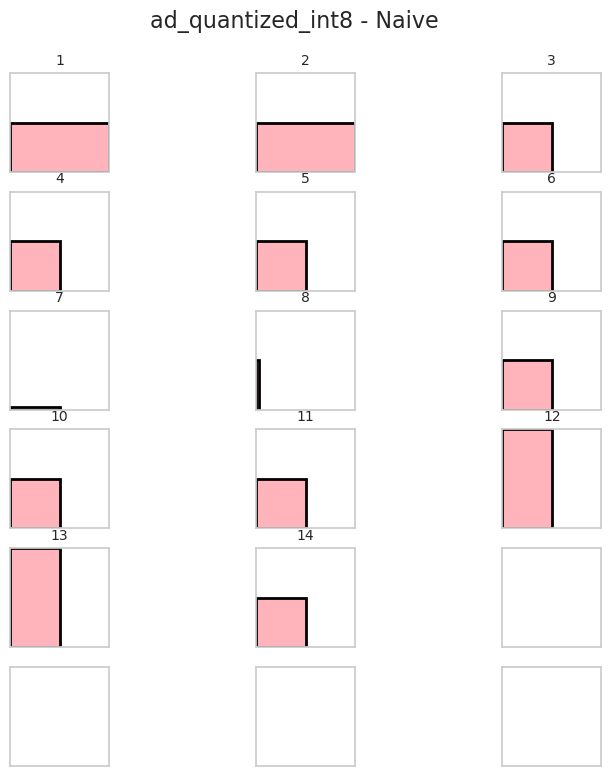

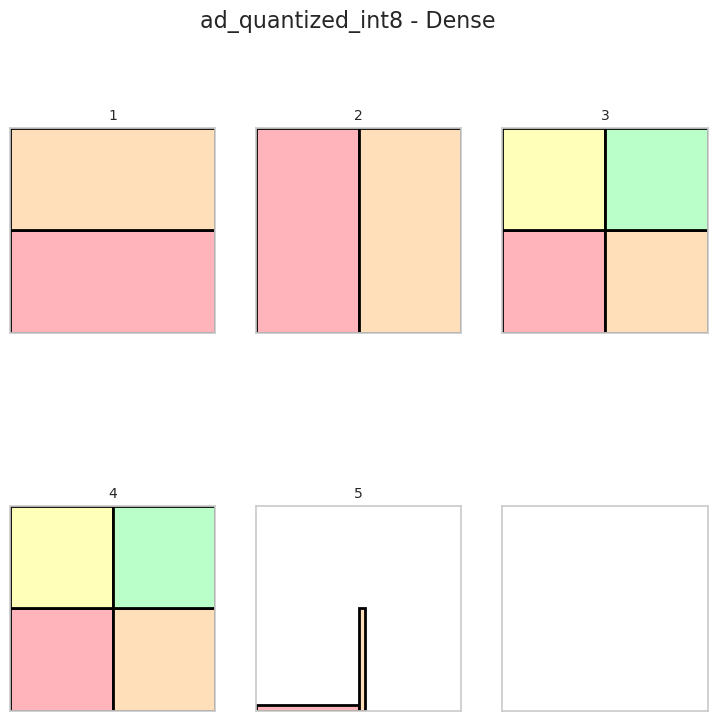

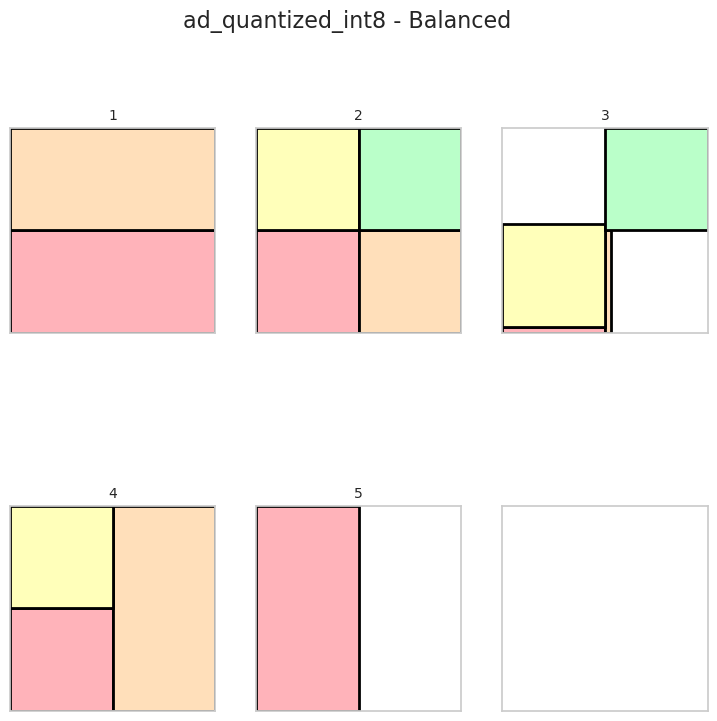

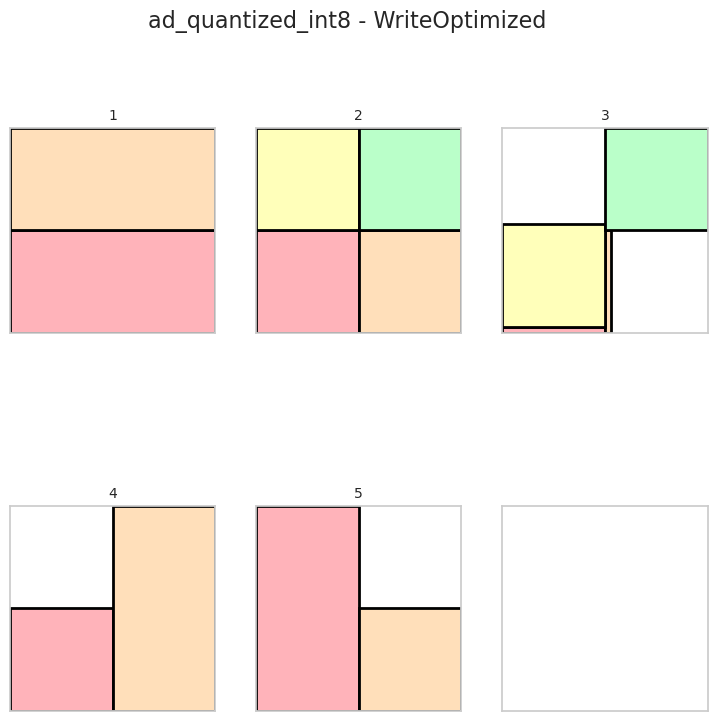

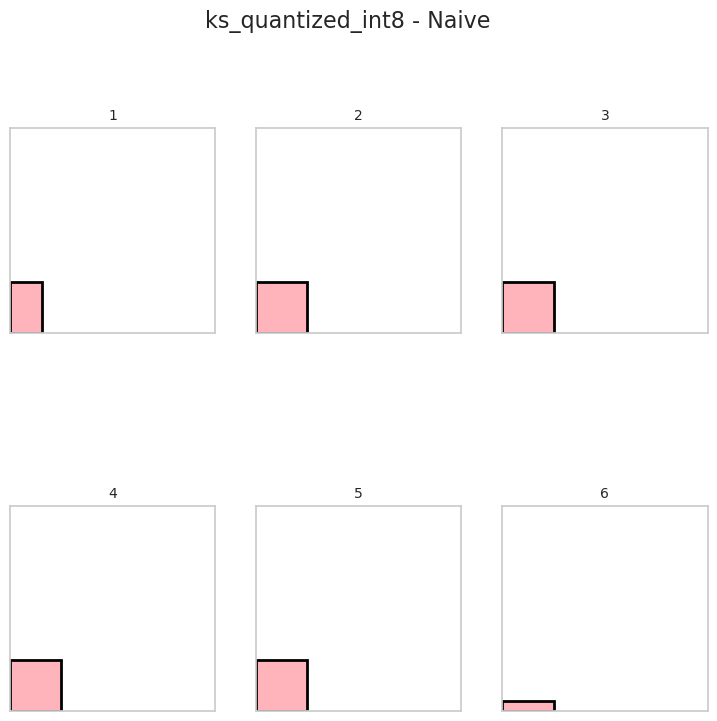

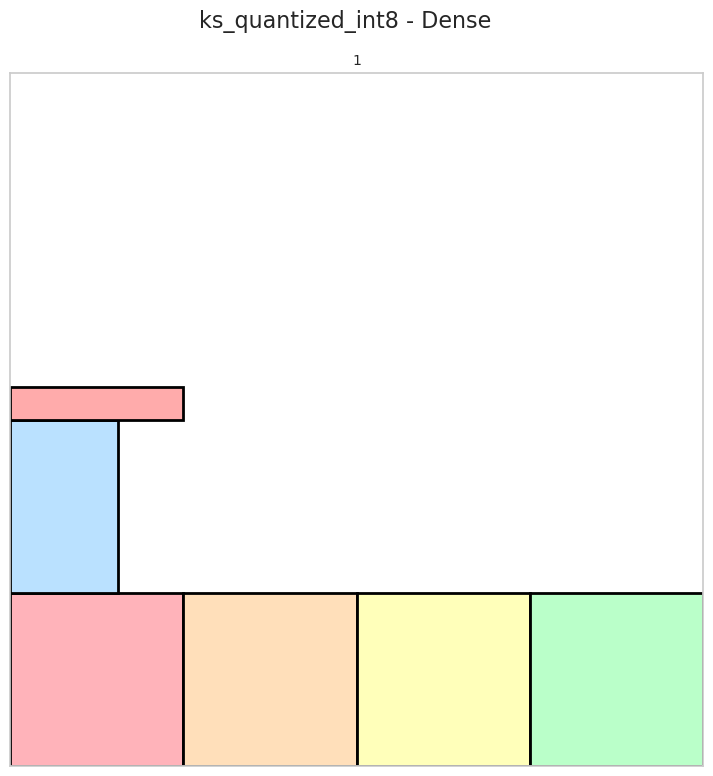

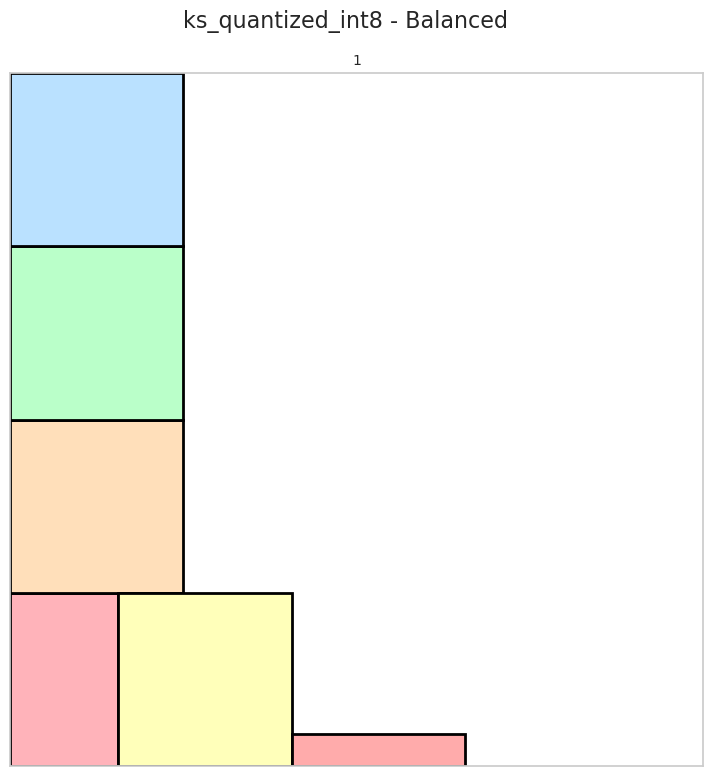

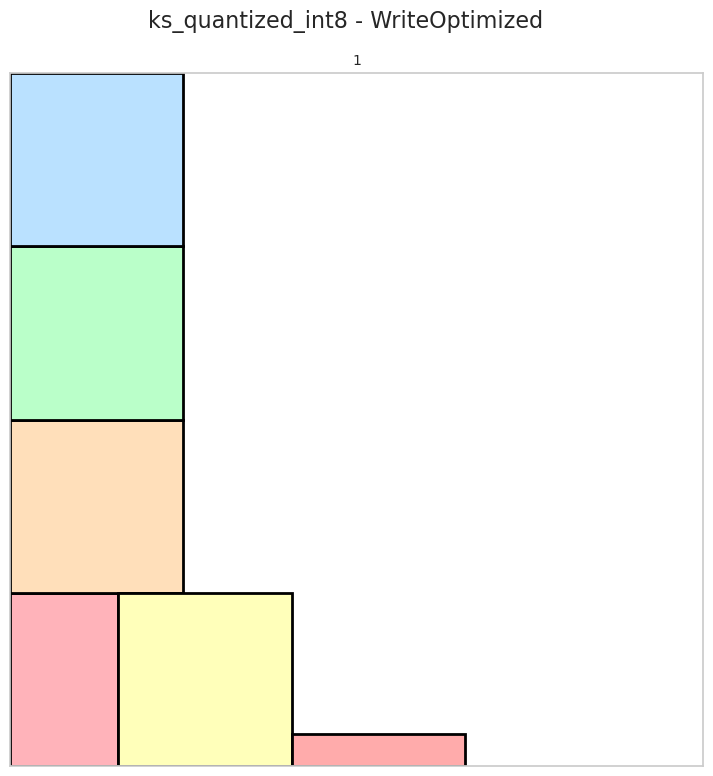

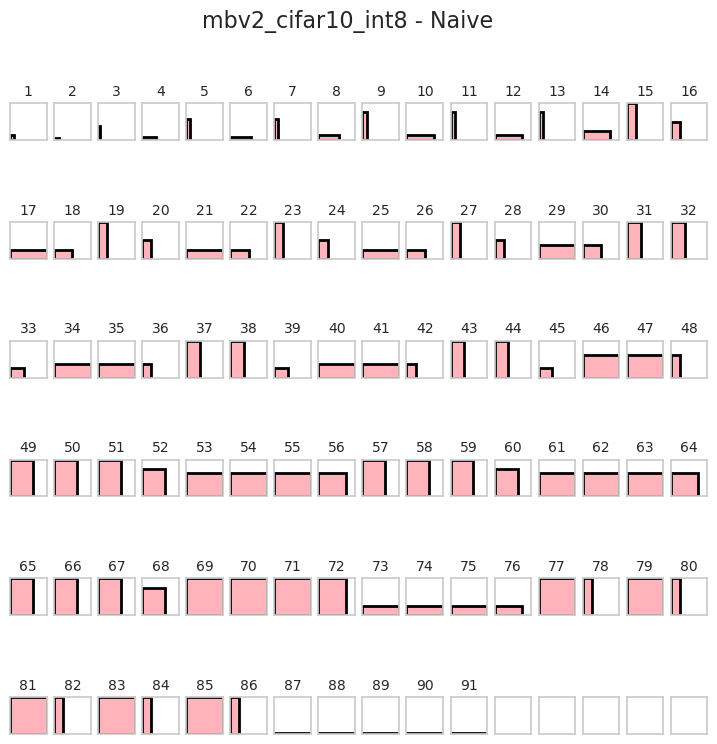

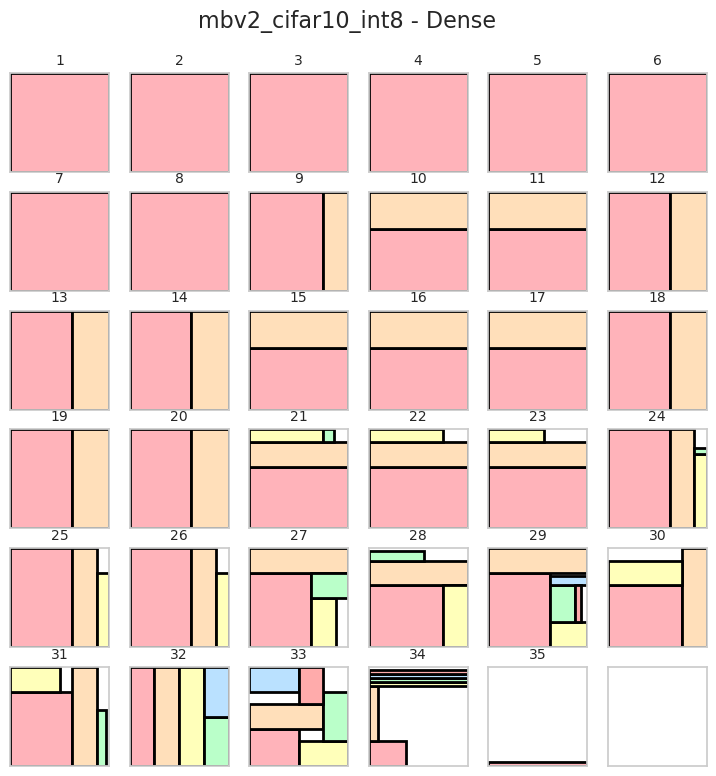

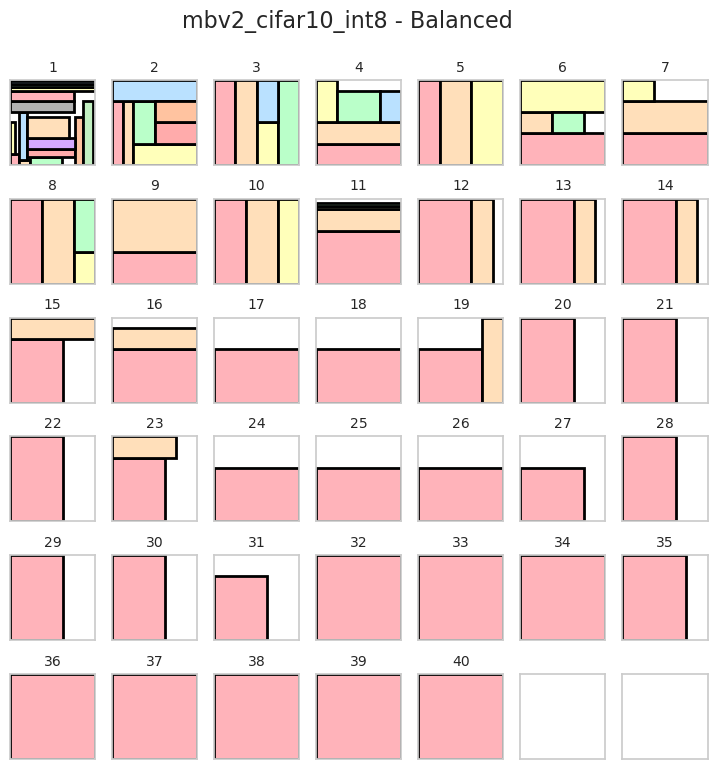

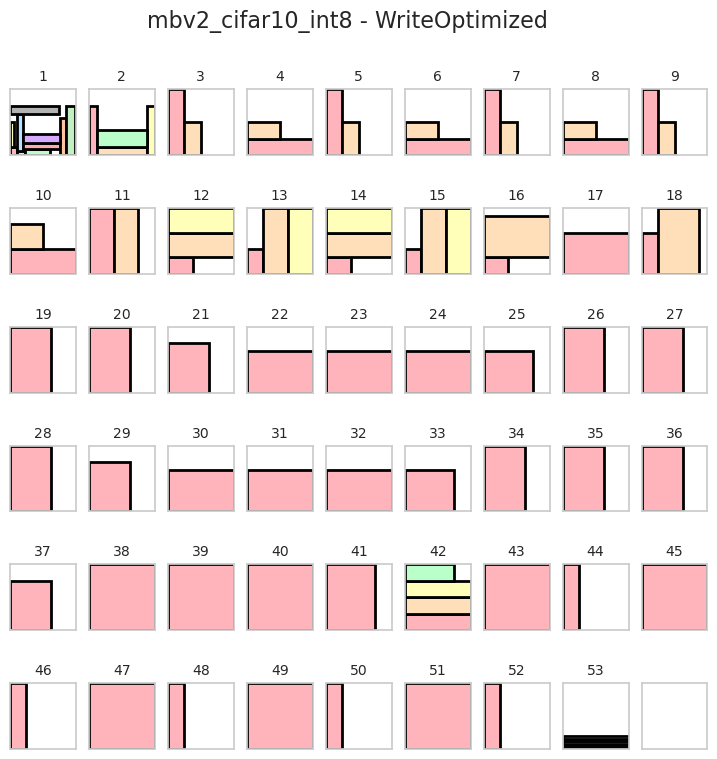

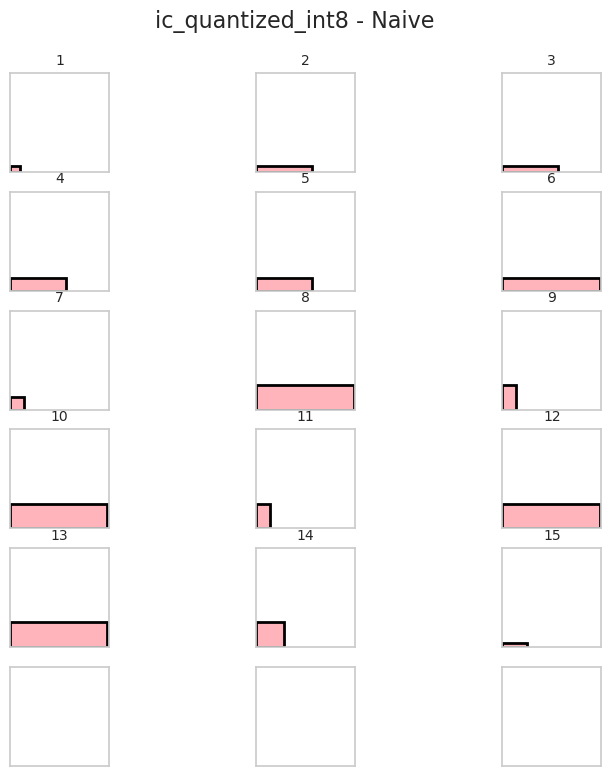

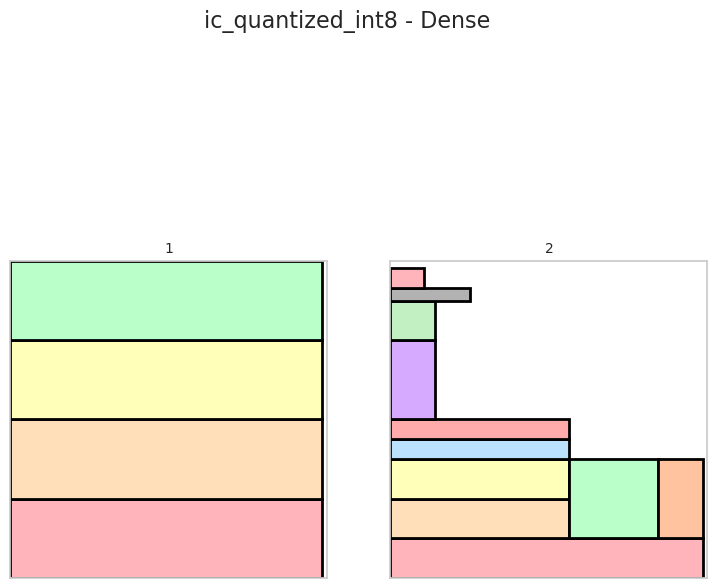

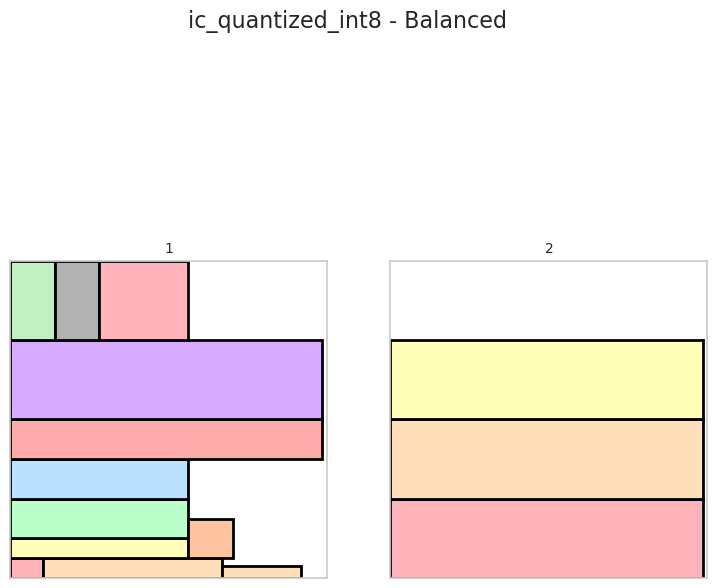

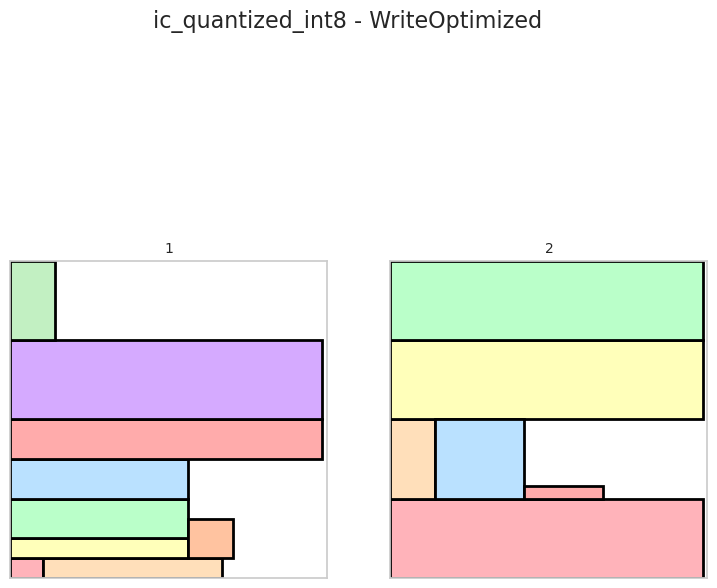

In [85]:
# Setup sweeps for packing experiments

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packers = ['Naive', 'Dense', 'Balanced', 'WriteOptimized']


core_size = (256, 256)

for i, modelpath in enumerate(modelpaths):
    for j, packer_name in enumerate(packers):
        nx_model = onnx.load(modelpath)
        packer = pu.get_packer_by_type(packer_name)
        u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer)
        if not u_marped.success:
            print(f"Packing failed for {modelpath} with packer {packer_name}")
            continue
        u_marped.plot(name=f"{modelpath.split('/')[-1].split('.')[0]} - {packer_name}", filepath=f'images/packings/{modelpath.split("/")[-1].split(".")[0]}_{packer_name}.svg')

In [ ]:
# Try compiling (most) models with all packers
# We avoid compiling MBv2 because that's huge

from marp.compile import compile

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    # 'onnx_models/mbv2_cifar10_int8.onnx', # warning: compiling mbv2 is extremely slow with poor PCs
    'onnx_models/ic_quantized_int8.onnx'
]

packers = ['Naive', 'Dense', 'Balanced', 'WriteOptimized']

core_size = (256, 256)
dwc_core_size = 32

for i, modelpath in enumerate(modelpaths):
    for j, packer_name in enumerate(packers):
        nx_model = onnx.load(modelpath)
        packer = pu.get_packer_by_type(packer_name)

        # Generate a fake input dictionary (used to infer the shape of intermediate tensors)
        input_name = nx_model.graph.input[0].name
        input_shape = [d.dim_value for d in nx_model.graph.input[0].type.tensor_type.shape.dim]
        if input_shape[0] > 1:
            nx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value = 1
            input_shape[0] = 1
        input_dict = {
            input_name: np.random.rand(*input_shape).astype(np.float32)
        }

        commands = compile.traverse_and_compile_nx_graph(
            nx_model      = nx_model,
            input_dict    = input_dict,
            imc_core_size = core_size,
            dwc_core_size = dwc_core_size,
            packer        = packer
        )  


# vs Core Size

In [12]:
import seaborn as sns
import ast

model_dict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet'
}

df = pd.read_csv('mlperftiny_marp_sweep.csv')
df['core_size'] = df['core_size'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['Cell Writes'] = df['bin_writes'] * df['core_size'].apply(lambda x: x[0] * x[1])
df['ModelName'] = df['ModelName'].apply(lambda x: model_dict.get(x, x))
df

,core_size,utilization,bin_writes,nbins,PackerArgs,ModelName,Cell Writes
0,"(256, 256)",0.287946,15,14,Naive,FC-AE,983040
1,"(256, 256)",0.806250,7,5,OFF_BBF_MR,FC-AE,458752
2,"(256, 256)",0.806250,6,5,OFF_BNF_MR,FC-AE,393216
3,"(256, 256)",0.806250,7,5,OFF_BFF_MR,FC-AE,458752
4,"(256, 256)",0.806250,7,5,ON_BBF_MR,FC-AE,458752
5,"(256, 256)",0.806250,6,5,ON_BNF_MR,FC-AE,393216
6,"(256, 256)",0.806250,7,5,ON_BFF_MR,FC-AE,458752
7,"(512, 512)",0.083984,13,12,Naive,FC-AE,3407872
8,"(512, 512)",0.503906,4,2,OFF_BBF_MR,FC-AE,1048576
9,"(512, 512)",0.503906,3,2,OFF_BNF_MR,FC-AE,786432


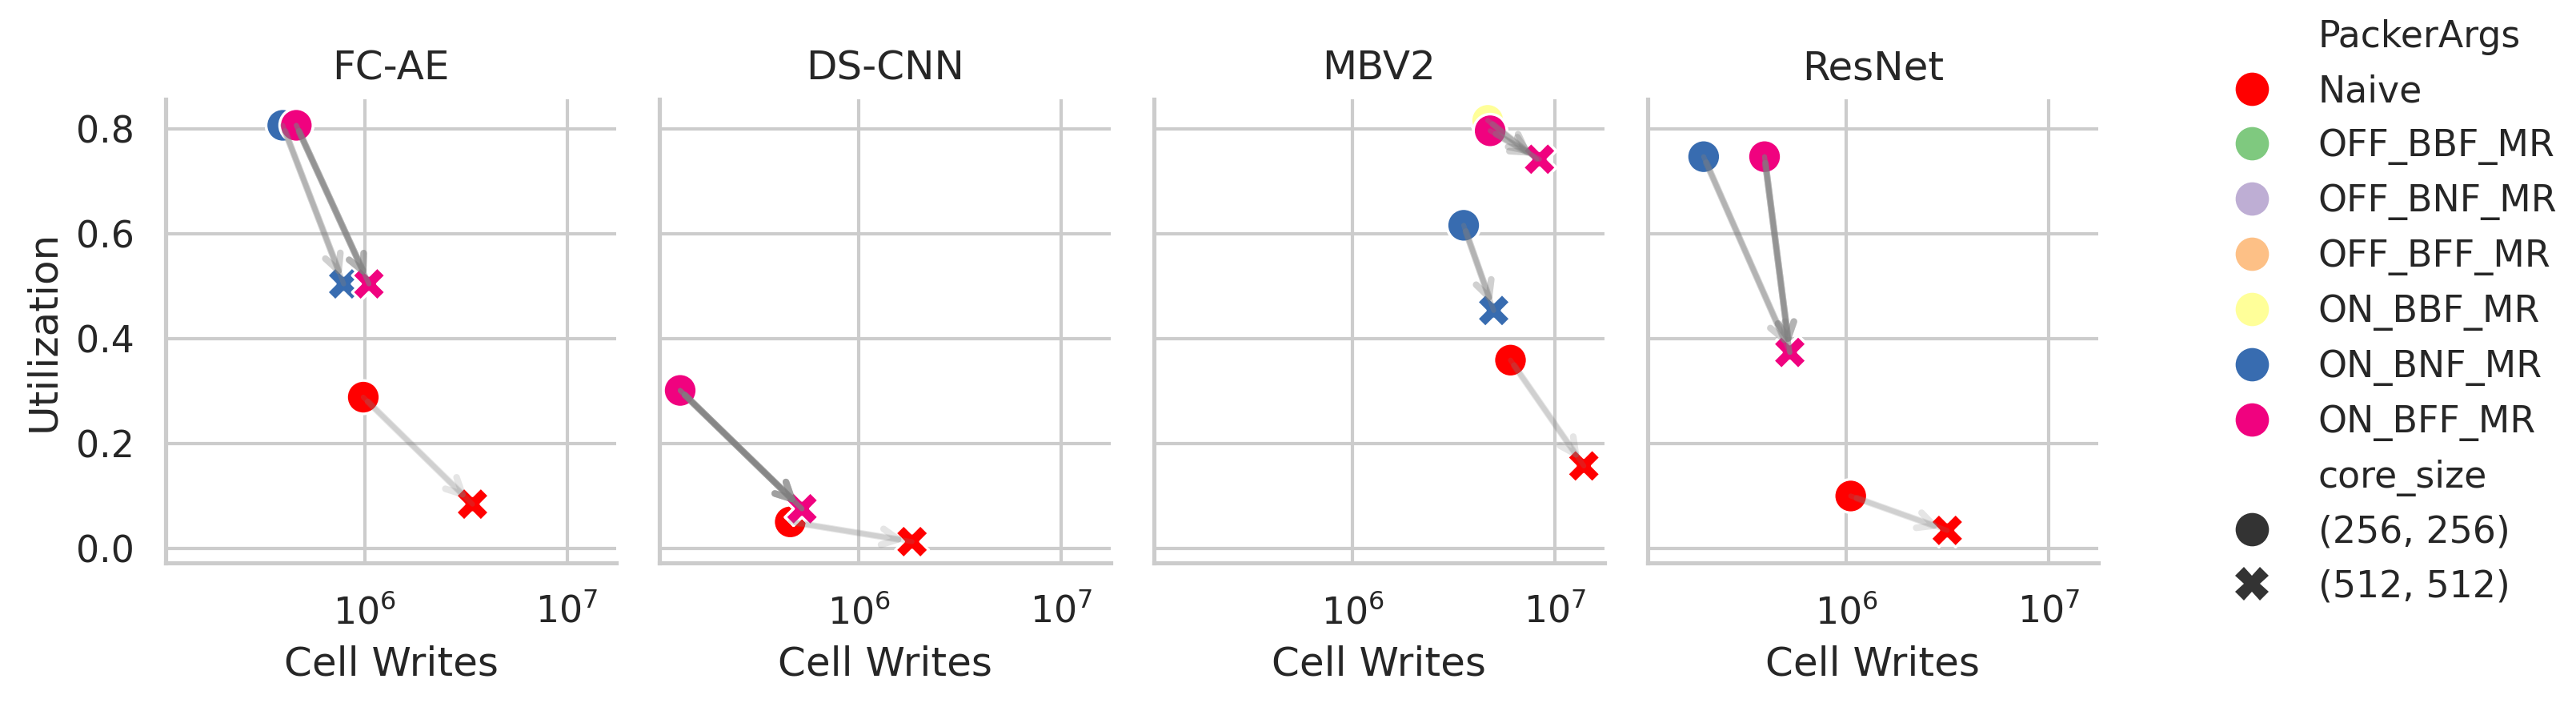

In [ ]:
plot_df = df

# Scatter plot of bin writes vs utilization with core size as hue
plot_df['Marker'] = plot_df['PackerArgs'].apply(lambda x: '*' if x == 'Naive' else 'o')
plot_df['Color'] = plot_df['PackerArgs'].apply(lambda x: 'red' if x == 'Naive' else None)

# Create a custom palette for PackerArgs: 'Naive' is red, others follow Accent palette
accent_colors = sns.color_palette('Accent', n_colors=plot_df['PackerArgs'].nunique() - 1)
packer_args = [arg for arg in plot_df['PackerArgs'].unique() if arg != 'Naive']
custom_palette = {'Naive': 'red'}
for arg, color in zip(packer_args, accent_colors):
    custom_palette[arg] = color

import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

g = sns.relplot(
    data=plot_df,
    x='Cell Writes',
    y='utilization',
    style='core_size',
    col='ModelName',
    hue='PackerArgs',
    palette=custom_palette,
    kind='scatter',
    s=100
)

g.figure.set_size_inches(9, 3)
g.figure.set_dpi(300)

# Draw lines with directional arrows between points of the same ModelName and PackerArgs, across core_size
for ax, col_val in zip(g.axes.flat, g.col_names):
    for packer_arg in plot_df['PackerArgs'].unique():
        # Only select data for the current subplot (col_val is ModelName)
        subset = plot_df[(plot_df['ModelName'] == col_val) & (plot_df['PackerArgs'] == packer_arg)]
        if len(subset) > 1:
            subset_sorted = subset.sort_values(by='core_size')
            x = subset_sorted['Cell Writes'].values
            y = subset_sorted['utilization'].values
            ax.plot(x, y, linestyle='-', alpha=0.2, color='gray')
            for i in range(len(x)-1):
                ax.annotate(
                    '', 
                    xy=(x[i+1], y[i+1]), 
                    xytext=(x[i], y[i]), 
                    arrowprops=dict(arrowstyle='->', color='gray', lw=2, alpha=0.2)
                )

# set legend outside
g._legend.set_bbox_to_anchor((1.01, 1))
g._legend.set_loc('upper left')

g.set_axis_labels('Cell Writes', 'Utilization')

# Set log x
g.set(xscale='log')

# Remove everything before = in the titles
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split('=')[-1].strip())

plt.tight_layout()
plt.savefig('images/utilization_core_size_cell_writes.svg')

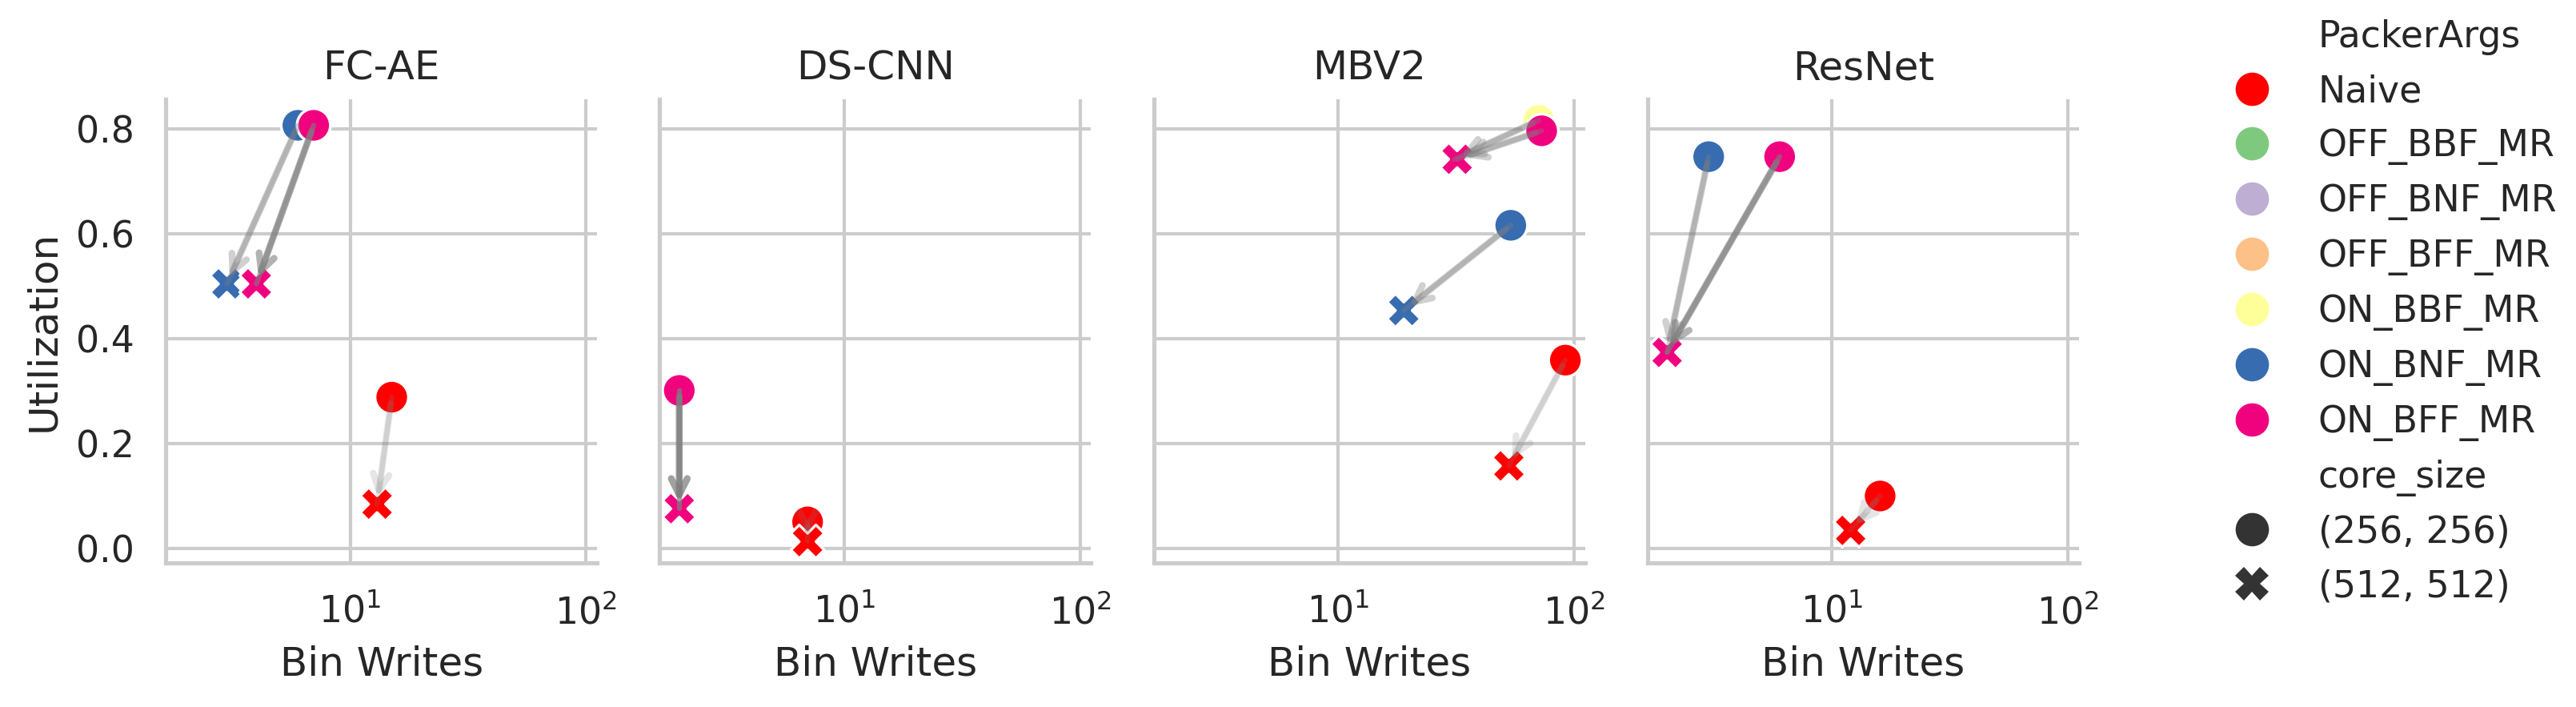

In [28]:
g = sns.relplot(
    data=plot_df,
    x='bin_writes',
    y='utilization',
    style='core_size',
    col='ModelName',
    hue='PackerArgs',
    palette=custom_palette,
    kind='scatter',
    s=100
)

g.figure.set_size_inches(9, 3)
g.figure.set_dpi(300)

# Draw lines with directional arrows between points of the same ModelName and PackerArgs, across core_size
for ax, col_val in zip(g.axes.flat, g.col_names):
    for packer_arg in plot_df['PackerArgs'].unique():
        # Only select data for the current subplot (col_val is ModelName)
        subset = plot_df[(plot_df['ModelName'] == col_val) & (plot_df['PackerArgs'] == packer_arg)]
        if len(subset) > 1:
            subset_sorted = subset.sort_values(by='core_size')
            x = subset_sorted['bin_writes'].values
            y = subset_sorted['utilization'].values
            ax.plot(x, y, linestyle='-', alpha=0.2, color='gray')
            for i in range(len(x)-1):
                ax.annotate(
                    '', 
                    xy=(x[i+1], y[i+1]), 
                    xytext=(x[i], y[i]), 
                    arrowprops=dict(arrowstyle='->', color='gray', lw=2, alpha=0.2)
                )

# set legend outside
g._legend.set_bbox_to_anchor((1.01, 1))
g._legend.set_loc('upper left')

g.set_axis_labels('Bin Writes', 'Utilization')

# Set log x
g.set(xscale='log')

# Remove everything before = in the titles
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split('=')[-1].strip())

plt.tight_layout()
plt.savefig('images/utilization_core_size_bin_writes.svg')

# Analysis of effects of core size against model size

In [ ]:
df

,core_size,utilization,bin_writes,nbins,PackerArgs,ModelName,Cell Writes,Marker,Color,ModelSize,Cell Writes Diff,Utilization Diff
0,"(256, 256)",0.287946,15,14,Naive,FC-AE,983040,*,red,270000,0,0.000000
1,"(256, 256)",0.806250,7,5,OFF_BBF_MR,FC-AE,458752,o,None,270000,0,0.000000
2,"(256, 256)",0.806250,6,5,OFF_BNF_MR,FC-AE,393216,o,None,270000,0,0.000000
3,"(256, 256)",0.806250,7,5,OFF_BFF_MR,FC-AE,458752,o,None,270000,0,0.000000
4,"(256, 256)",0.806250,7,5,ON_BBF_MR,FC-AE,458752,o,None,270000,0,0.000000
5,"(256, 256)",0.806250,6,5,ON_BNF_MR,FC-AE,393216,o,None,270000,0,0.000000
6,"(256, 256)",0.806250,7,5,ON_BFF_MR,FC-AE,458752,o,None,270000,0,0.000000
7,"(512, 512)",0.083984,13,12,Naive,FC-AE,3407872,*,red,270000,2424832,-0.203962
8,"(512, 512)",0.503906,4,2,OFF_BBF_MR,FC-AE,1048576,o,None,270000,589824,-0.302344
9,"(512, 512)",0.503906,3,2,OFF_BNF_MR,FC-AE,786432,o,None,270000,393216,-0.302344


In [11]:
plot_df

,core_size,utilization,bin_writes,nbins,PackerArgs,ModelName,Cell Writes,ModelSize,Cell Writes Diff,Utilization Diff
7,"(512, 512)",0.083984,13,12,Naive,ad_quantized_int8,3407872,NaN,246.666667,0.203962
8,"(512, 512)",0.503906,4,2,OFF_BBF_MR,ad_quantized_int8,1048576,NaN,128.571429,0.302344
9,"(512, 512)",0.503906,3,2,OFF_BNF_MR,ad_quantized_int8,786432,NaN,100.000000,0.302344
10,"(512, 512)",0.503906,4,2,OFF_BFF_MR,ad_quantized_int8,1048576,NaN,128.571429,0.302344
11,"(512, 512)",0.503906,4,2,ON_BBF_MR,ad_quantized_int8,1048576,NaN,128.571429,0.302344
12,"(512, 512)",0.503906,3,2,ON_BNF_MR,ad_quantized_int8,786432,NaN,100.000000,0.302344
13,"(512, 512)",0.503906,4,2,ON_BFF_MR,ad_quantized_int8,1048576,NaN,128.571429,0.302344
21,"(512, 512)",0.012533,7,6,Naive,ks_quantized_int8,1835008,NaN,300.000000,0.037598
22,"(512, 512)",0.075195,2,1,OFF_BBF_MR,ks_quantized_int8,524288,NaN,300.000000,0.225586
23,"(512, 512)",0.075195,2,1,OFF_BNF_MR,ks_quantized_int8,524288,NaN,300.000000,0.225586


Text(-50.33333333333334, 0.5, '% Increase in Cell Writes')

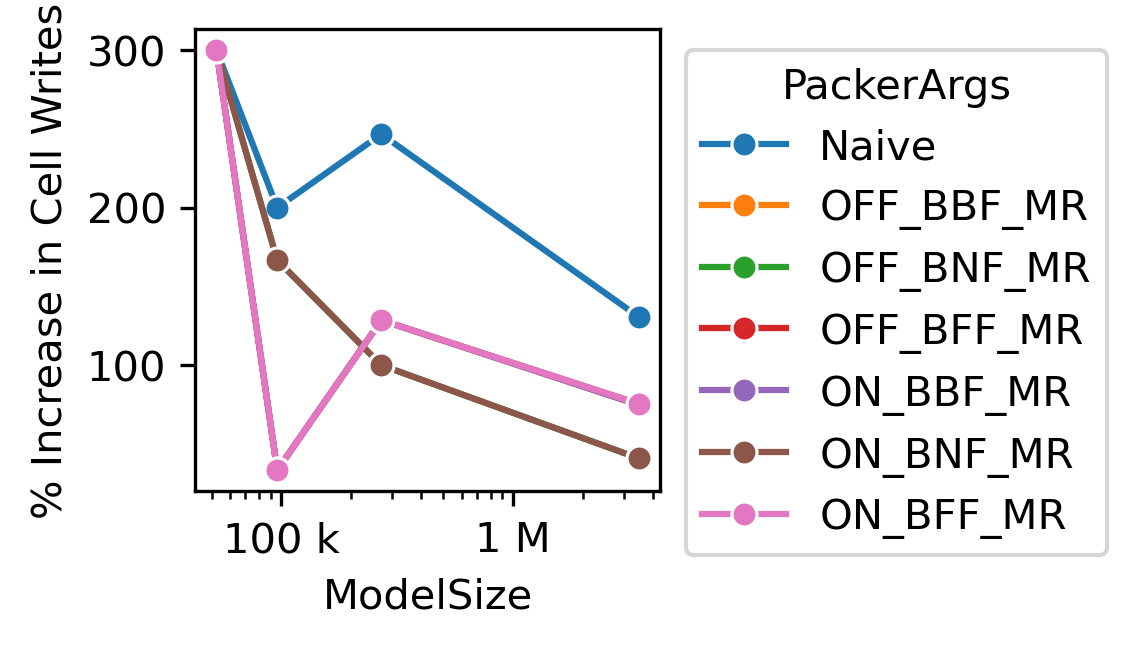

In [16]:
model_size_dict = {
    'DS-CNN': 52500,
    'ResNet': 96000,
    'FC-AE': 270000,
    'MBV2': 3500000
}

df['ModelSize'] = df['ModelName'].map(model_size_dict)

# Subtract the Cell Writes of (512,512) from (256,256) for each ModelName and PackerArgs
df['Cell Writes Diff'] = df.groupby(['ModelName', 'PackerArgs'])['Cell Writes'].transform(
    lambda x: ((x-x.iloc[0])/x.iloc[0])*100 if len(x) > 1 else 0
)
# Subtract the utilization of (512,512) from (256,256) for each ModelName and PackerArgs
df['Utilization Diff'] = df.groupby(['ModelName', 'PackerArgs'])['utilization'].transform(
    lambda x: x - x.iloc[0] if len(x) > 1 else 0
)
df['Utilization Diff'] = -df['Utilization Diff']

# Create a new DataFrame for the plot
plot_df = df[df['core_size'] == (512, 512)]

g = sns.lineplot(
    data=plot_df,
    x='ModelSize',
    y='Cell Writes Diff',
    hue='PackerArgs',
    marker='o'
)
g.set(xscale='log')
g.figure.set_size_inches(2, 2)
g.figure.set_dpi(300)

# Set legend outside
g.legend_.set_bbox_to_anchor((1.01, 1))
g.legend_.set_loc('upper left')

# Set engformatter
from matplotlib.ticker import EngFormatter
eng_format = EngFormatter()
g.xaxis.set_major_formatter(eng_format)
# g.yaxis.set_major_formatter(eng_format)

plt.savefig('images/cell_writes_percentchange_model_size.svg')

# Set y axis label
g.set_ylabel('% Increase in Cell Writes')


<>:47: SyntaxWarning: invalid escape sequence '\D'
<>:47: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1221/2019550788.py:47: SyntaxWarning: invalid escape sequence '\D'
  g.set_ylabel('$\Delta$ Cell Writes')


Text(-46.58333333333334, 0.5, '$\\Delta$ Cell Writes')

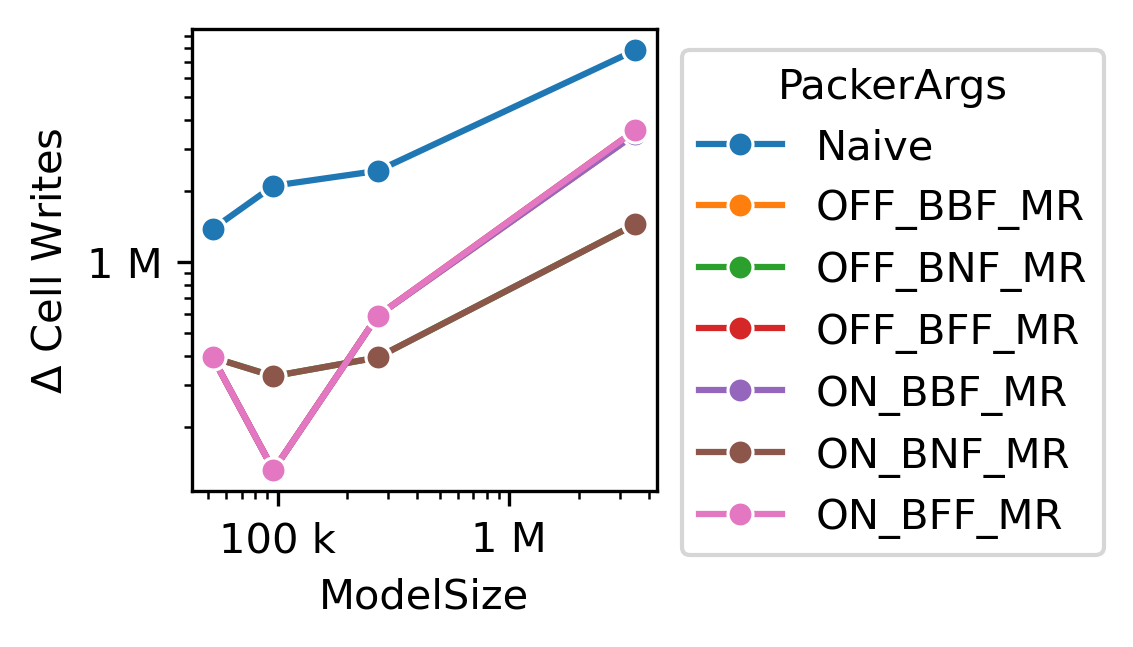

In [20]:
model_size_dict = {
    'DS-CNN': 52500,
    'ResNet': 96000,
    'FC-AE': 270000,
    'MBV2': 3500000
}

df['ModelSize'] = df['ModelName'].map(model_size_dict)

# Subtract the Cell Writes of (512,512) from (256,256) for each ModelName and PackerArgs
df['Cell Writes Diff'] = df.groupby(['ModelName', 'PackerArgs'])['Cell Writes'].transform(
    lambda x: x - x.iloc[0] if len(x) > 1 else 0
)
# Subtract the utilization of (512,512) from (256,256) for each ModelName and PackerArgs
df['Utilization Diff'] = df.groupby(['ModelName', 'PackerArgs'])['utilization'].transform(
    lambda x: x - x.iloc[0] if len(x) > 1 else 0
)
df['Utilization Diff'] = -df['Utilization Diff']

# Create a new DataFrame for the plot
plot_df = df[df['core_size'] == (512, 512)]

g = sns.lineplot(
    data=plot_df,
    x='ModelSize',
    y='Cell Writes Diff',
    hue='PackerArgs',
    marker='o'
)
g.set(xscale='log')
g.set(yscale='log')
g.figure.set_size_inches(2, 2)
g.figure.set_dpi(300)

# Set legend outside
g.legend_.set_bbox_to_anchor((1.01, 1))

# Set engformatter
from matplotlib.ticker import EngFormatter
eng_format = EngFormatter()
g.xaxis.set_major_formatter(eng_format)
g.yaxis.set_major_formatter(eng_format)

plt.savefig('images/cell_writes_diff_model_size.svg')

# Set y axis label
g.set_ylabel('$\Delta$ Cell Writes')


In [50]:
df

,core_size,utilization,bin_writes,nbins,PackerArgs,ModelName,Cell Writes,Marker,Color,ModelSize,Cell Writes Diff,Utilization Diff
0,"(256, 256)",0.287946,15,14,Naive,FC-AE,983040,*,red,270000,0,-0.000000
1,"(256, 256)",0.806250,7,5,OFF_BBF_MR,FC-AE,458752,o,None,270000,0,-0.000000
2,"(256, 256)",0.806250,6,5,OFF_BNF_MR,FC-AE,393216,o,None,270000,0,-0.000000
3,"(256, 256)",0.806250,7,5,OFF_BFF_MR,FC-AE,458752,o,None,270000,0,-0.000000
4,"(256, 256)",0.806250,7,5,ON_BBF_MR,FC-AE,458752,o,None,270000,0,-0.000000
5,"(256, 256)",0.806250,6,5,ON_BNF_MR,FC-AE,393216,o,None,270000,0,-0.000000
6,"(256, 256)",0.806250,7,5,ON_BFF_MR,FC-AE,458752,o,None,270000,0,-0.000000
7,"(512, 512)",0.083984,13,12,Naive,FC-AE,3407872,*,red,270000,2424832,0.203962
8,"(512, 512)",0.503906,4,2,OFF_BBF_MR,FC-AE,1048576,o,None,270000,589824,0.302344
9,"(512, 512)",0.503906,3,2,OFF_BNF_MR,FC-AE,786432,o,None,270000,393216,0.302344
